# Data

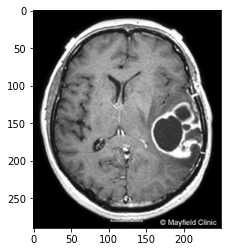

In [6]:
import matplotlib.pyplot as plt
from PIL import Image


with open('train_data/train_Brain_Tumor/Cancer (1000).jpg', 'rb') as img_file:

    img = Image.open(img_file)

    plt.imshow(img)
    plt.show()
# ill


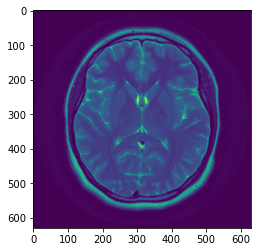

In [8]:
import matplotlib.pyplot as plt
from PIL import Image


with open('train_data/train_Healthy/Not Cancer  (1).jpeg', 'rb') as img_file:

    img = Image.open(img_file)

    plt.imshow(img)
    plt.show()

# healthy


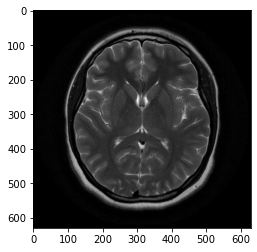

In [10]:
# Due to the different channel of the images( some are 3 while some are 1), I chose to convert them all to gray
import matplotlib.pyplot as plt
from PIL import Image

with open('train_data/train_Healthy/Not Cancer  (1).jpeg', 'rb') as img_file:
    img = Image.open(img_file)
    # 轉換為灰階
    gray_img = img.convert('L')
    plt.imshow(gray_img, cmap='gray')
    plt.show()


In [20]:
import glob
ffs = glob.glob('train_data/*/*')
import imageio
data = []
for f in ffs:
  if 'Brain_Tumor' in f:
    data.append([f, 1])
  else:
    data.append([f, 0])

print(data[4000])
print(data[1000])
# make the ill to label1, healthy to label0

['train_data\\train_Healthy\\Not Cancer  (935).jpg', 0]
['train_data\\train_Brain_Tumor\\Cancer (1988).jpg', 1]


#  Network

In [21]:
import glob
import imageio
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import albumentations as A
import tqdm
import random
from sklearn.metrics import f1_score
import torchvision.models as models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


In [ ]:
epochs = 10

In [ ]:
transform = A.Compose([
    A.Resize(224, 224), # Must be 224x224
    A.ShiftScaleRotate(p=0.5),
    A.OpticalDistortion(p=0.5),
    A.GridDistortion(p=0.5),
])


In [ ]:
for epoch in range(epochs):
    model.train()  # 設定模型為訓練模式
    train_loss = []
    pbar = tqdm.tqdm(train_data)
    for im, label in pbar:
        # 讀取和處理圖像

        #im = np.expand_dims(im, axis=0)  # 1, 224, 224
        #im_d = torch.from_numpy(im.astype(np.float32)/255.0).to(device).unsqueeze(0).float()
        im_d = torch.from_numpy(im).to(device).float()
        images = im_d.to(device)
        labels = torch.from_numpy(np.array([label])).to(device)

        # 前向傳播和反向傳播
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())
        pbar.set_description(f'Loss: {loss.item():.3f}')
        loss.backward()
        optimizer.step()

    # 計算訓練集的平均損失
    train_loss_avg = np.mean(train_loss)
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss_avg:.3f}')

    # 驗證過程
    model.eval()  # 設定模型為評估模式
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for im, label in val_data:
          im_d = torch.from_numpy(im).to(device).float()
          images = im_d.to(device)
          labels = torch.from_numpy(np.array([label])).to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          val_labels.extend(labels.cpu().numpy())
          val_preds.extend(predicted.cpu().numpy())

    # 計算 F1 分數
    f1 = f1_score(val_labels, val_preds, average='binary')
    print(f'Epoch {epoch+1}/{epochs}, Validation F1 Score: {f1 :.3f}')

    # 保存模型
    torch.save(model.state_dict(), f'/model/MRI_epoch_{epoch}.pt')

In [ ]:



# 設置模型路徑
model_path = "MRI_epoch_9.pt"  

# 創建模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path))
model = model.to(device)




model.eval()


transform = A.Compose([
    A.Resize(224, 224),  
])




def predict(image_path, model, transform):

    im = imageio.imread(image_path)
    im = Image.fromarray(im).convert('L')
    im = np.array(im)
    im = transform(image=im)['image']
    im = np.stack([im]*3, axis=0)[None, ...] 
    #im = im[None, None, ...]
    im =  torch.from_numpy(im.astype(np.float32) / np.max(im)).to(device)

    with torch.no_grad():
        output = model(im)
        prediction = torch.argmax(output, dim=1).item()

    return prediction



def sort_key(filename):

    parts = os.path.splitext(os.path.basename(filename))[0].split('_')
    return int(parts[0])


image_files = glob.glob("/final_test_dataset/final_test_dataset/*")
image_files.sort(key=sort_key)  
predictions = []
import tqdm
for image_file in tqdm.tqdm(image_files):
    prediction = predict(image_file, model, transform)
    image_id = os.path.splitext(os.path.basename(image_file))[0].split('_')[0]  
    predictions.append([image_id, prediction])


output_csv = "submission.csv"
predictions_df = pd.DataFrame(predictions, columns=['id', 'label'])
predictions_df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")
